In [14]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

manual_seed = 999
print("Random seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Random seed:  999


In [15]:
dataroot = "/Volumes/Data/Data/celeba"
workers = 2
batch_size = 128
image_size = 64

nc = 3 # number of channels
nz = 100 # size of latent z vector (size of generator input)
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator

num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 0

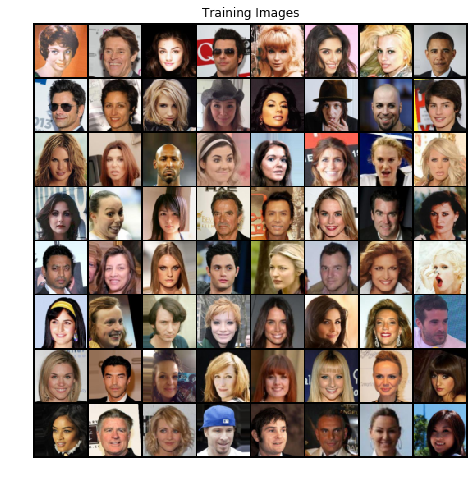

In [17]:
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))
    ]))

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
grid = vutils.make_grid(
        real_batch[0].to(device)[:64],
        padding=2,
        normalize=True).cpu()
    
plt.imshow(np.transpose(grid, (1, 2, 0)))


In [31]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator

In [32]:
class Generator(nn.Module):
    def __init__(self, npgu):
        super().__init__()
        self.ngpu = npgu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # state size: ngf*8 x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size: ngf*4 x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size: ngf*2 x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size: ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: nc x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [33]:
net_gen = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    net_gen = nn.DataParallel(net_gen, list(range(ngpu)))

net_gen.apply(weights_init)

print(net_gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [42]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: ndf x 32 x 32
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 4 x 4
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)


In [43]:
net_disc = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    net_disc = nn.DataParallel(net_disc, list(range(ngpu)))

net_disc.apply(weights_init)

print(net_disc)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [44]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizer_d = optim.Adam(
    net_disc.parameters(),
    lr=lr,
    betas=(beta1, 0.999))
optimizer_g = optim.Adam(
    net_gen.parameters(),
    lr=lr,
    betas=(beta1, 0.999))


# Training

In [47]:
# Lists to keep track of progress
img_list = []
g_losses = []
d_losses = []
iters = 0

print("Starting training loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        ### Update discriminator network:
        ### maximize log(D(x)) + log(1 - D(G(z)))
        
        ## Train with real batch
        net_disc.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through discriminator
        output = net_disc(real_cpu).view(-1)
        # Calculate loss on real batch
        err_d_real = criterion(output, label)
        err_d_real.backward()
        D_x = output.mean().item()
      
        ## Train with fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = net_gen(noise)
        label.fill_(fake_label)
        output = net_disc(fake.detach()).view(-1)
        err_d_fake = criterion(output, label)
        err_d_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Add the gradients from the real and fake batches
        err_d = err_d_real + err_d_fake
        # Update discriminator
        optimizer_d.step()
        
        
        ### Update generator network:
        ### maximize log(D(G(z)))
        
        net_gen.zero_grad()
        label.fill_(real_label)
        output = net_disc(fake).view(-1)
        err_g = criterion(output, label)
        err_g.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_g.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err_d.item(), err_g.item(), D_x, D_G_z1, D_G_z2))

        g_losses.append(err_g.item)
        d_losses.append(err_d.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1        

Starting training loop...
[0/5][0/1583]	Loss_D: 0.3914	Loss_G: 6.7737	D(x): 0.9516	D(G(z)): 0.2499 / 0.0018
[0/5][50/1583]	Loss_D: 0.0064	Loss_G: 30.3284	D(x): 0.9943	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.0037	Loss_G: 38.6950	D(x): 0.9966	D(G(z)): 0.0000 / 0.0000


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/erict/miniconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/erict/miniconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/erict/miniconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/erict/miniconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/erict/miniconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/erict/miniconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/erict/miniconda3/envs/tor

KeyboardInterrupt: 